**Chapter 13 – Convolutional Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 13._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [105]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [106]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [107]:
import tensorflow as tf

# Convolutional layer

In [108]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

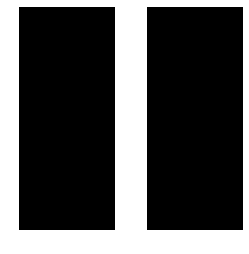

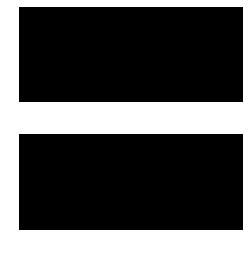

In [109]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [110]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [111]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

Saving figure china_original


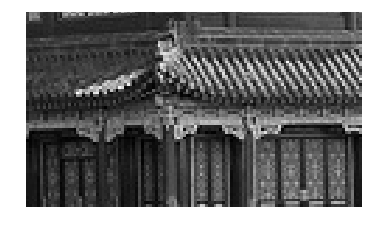

In [112]:
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical


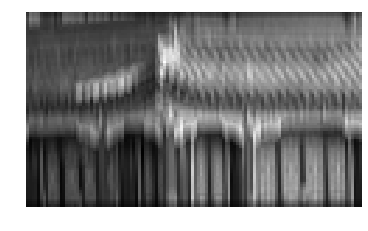

In [113]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

Saving figure china_horizontal


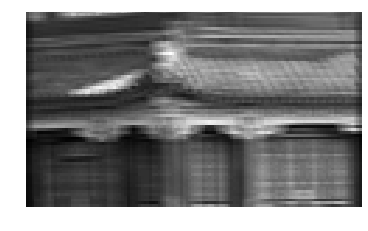

In [114]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

## Simple example

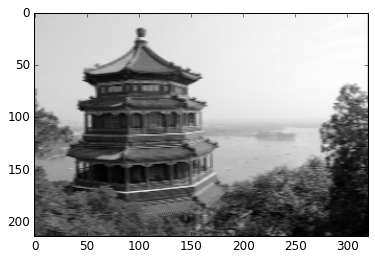

In [115]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

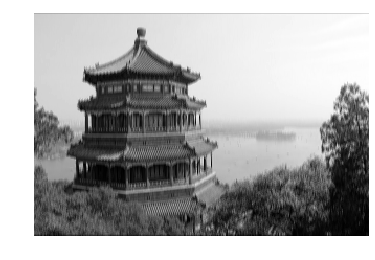

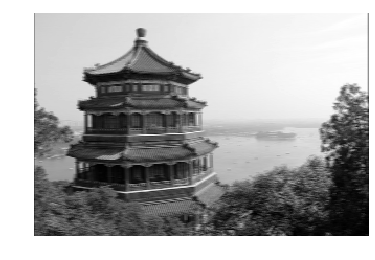

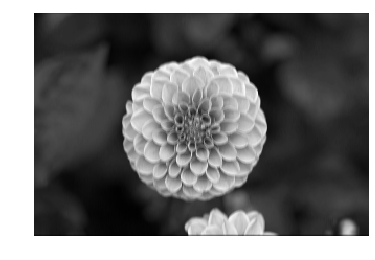

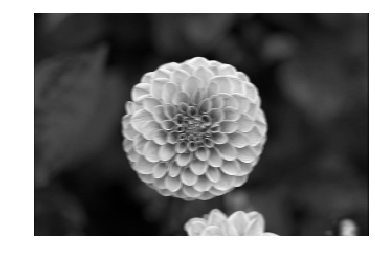

In [116]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

Using `tf.layers.conv2d()`:

In [117]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

In [118]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

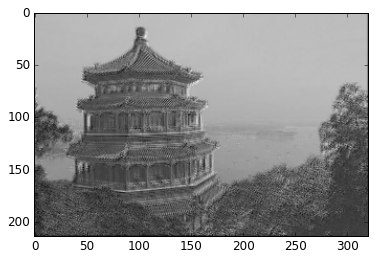

In [119]:
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

## VALID vs SAME padding

In [120]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[ 184.]
   [ 389.]]]]
SAME:
 [[[[ 143.]
   [ 348.]
   [ 204.]]]]


In [121]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# Pooling layer

In [122]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

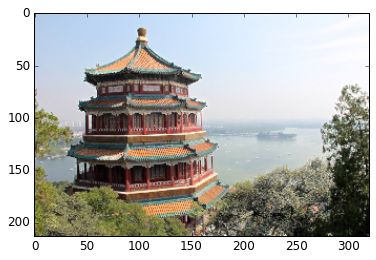

In [123]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

Saving figure china_original


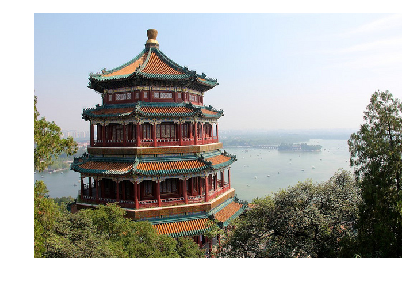

Saving figure china_max_pool


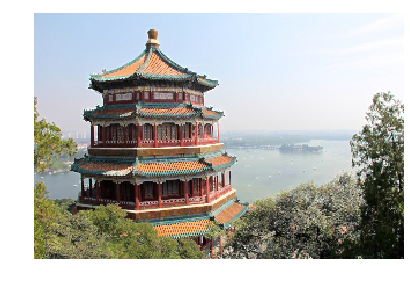

In [124]:
plot_color_image(dataset[0])
save_fig("china_original")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.show()

# MNIST

Note: instead of using the `fully_connected()`, `conv2d()` and `dropout()` functions from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()`, `conv2d()` and `dropout()` functions (respectively) from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

For all these functions:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).

The other main differences in `tf.layers.dense()` are:
* the `weights` parameter was renamed to `kernel` (and the weights variable is now named `"kernel"` rather than `"weights"`),
* the default activation is `None` instead of `tf.nn.relu`

The other main differences in `tf.layers.conv2d()` are:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the default `activation` is now `None` instead of `tf.nn.relu`.

The other main differences in `tf.layers.dropout()` are:
* it takes the dropout rate (`rate`) rather than the keep probability (`keep_prob`). Of course, `rate == 1 - keep_prob`,
* the `is_training` parameters was renamed to `training`.

In [25]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Note: if you are using Python 3.6 on OSX, you need to run the following command on terminal to install the certifi package of certificates because Python 3.6 on OSX has no certificates to validate SSL connections (see this [StackOverflow question](https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error)):

    $ /Applications/Python\ 3.6/Install\ Certificates.command

In [27]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [28]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.99 Test accuracy: 0.978
1 Train accuracy: 0.96 Test accuracy: 0.981
2 Train accuracy: 0.99 Test accuracy: 0.9869
3 Train accuracy: 0.98 Test accuracy: 0.9876
4 Train accuracy: 1.0 Test accuracy: 0.9876
5 Train accuracy: 0.99 Test accuracy: 0.9902
6 Train accuracy: 1.0 Test accuracy: 0.9892
7 Train accuracy: 0.99 Test accuracy: 0.99
8 Train accuracy: 1.0 Test accuracy: 0.9873
9 Train accuracy: 1.0 Test accuracy: 0.9882


# Exercise solutions

## 1. to 6.

See appendix A.

## 7. High Accuracy CNN for MNIST
Exercise: Build your own CNN and try to achieve the highest possible accuracy on MNIST.

The following CNN is similar to the one defined above, except using stride 1 for the second convolutional layer (rather than 2), with 25% dropout after the second convolutional layer, 50% dropout after the fully connected layer, and trained using early stopping. It achieves around 99.2% accuracy on MNIST. This is not state of the art, but it is not bad. Can you do better?

In [29]:
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Let's load the data:

In [30]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


The `get_model_params()` function gets the model's state (i.e., the value of all the variables), and the `restore_model_params()` restores a previous state. This is used to speed up early stopping: instead of storing the best model found so far to disk, we just save it to memory. At the end of training, we roll back to the best model found.

In [ ]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

Now let's train the model! This implementation of Early Stopping works like this:
* every 100 training iterations, it evaluates the model on the validation set,
* if the model performs better than the best model found so far, then it saves the model to RAM,
* if there is no progress for 100 evaluations in a row, then training is interrupted,
* after training, the code restores the best model found.

In [ ]:
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: mnist.validation.images,
                                                y: mnist.validation.labels})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                           y: mnist.validation.labels})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
                                        y: mnist.test.labels})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

## 8.  Classifying large images using Inception v3.

### 8.1.
Exercise: Download some images of various animals. Load them in Python, for example using the `matplotlib.image.mpimg.imread()` function or the `scipy.misc.imread()` function. Resize and/or crop them to 299 × 299 pixels, and ensure that they have just three channels (RGB), with no transparency channel. The images that the Inception model was trained on were preprocessed so that their values range from -1.0 to 1.0, so you must ensure that your images do too.

In [125]:
width = 299
height = 299
channels = 3

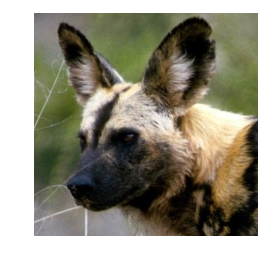

In [126]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

Ensure that the values are in the range [-1, 1] (as expected by the pretrained Inception model), instead of [0, 1]:

In [127]:
test_image = 2 * test_image - 1

## 8.2.
Exercise: Download the latest pretrained Inception v3 model: the checkpoint is available at https://github.com/tensorflow/models/tree/master/research/slim. The list of class names is available at https://goo.gl/brXRtZ, but you must insert a "background" class at the beginning.


In [128]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [129]:
fetch_pretrained_inception_v3()

In [130]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [131]:
class_names = ["background"] + load_class_names()

In [132]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

## 8.3.
Exercise: Create the Inception v3 model by calling the `inception_v3()` function, as shown below. This must be done within an argument scope created by the `inception_v3_arg_scope()` function. Also, you must set `is_training=False` and `num_classes=1001` [...]

In [133]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

### 8.4.
Exercise: Open a session and use the `Saver` to restore the pretrained model checkpoint you downloaded earlier.


In [134]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


### 8.5.
Run the model to classify the images you prepared. Display the top five predictions for each image, along with the estimated probability (the list of class names is available at https://goo.gl/brXRtZ). How accurate is the model?


In [135]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [136]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

276

In [137]:
class_names[most_likely_class_index]

'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus'

In [138]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 92.86%
dhole, Cuon alpinus: 1.13%
hyena, hyaena: 0.35%
red wolf, maned wolf, Canis rufus, Canis niger: 0.10%
European fire salamander, Salamandra salamandra: 0.04%


The model is quite accurate on this particular image: if makes the right prediction with high confidence.

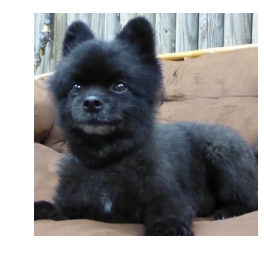

In [139]:
rebbi_image = mpimg.imread(os.path.join("images","cnn","rebbi.png"))[:, :, :channels]
plt.imshow(rebbi_image)
plt.axis("off")
plt.show()
rebbi_image = 2 * rebbi_image - 1

In [140]:
rebbi_test = rebbi_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: rebbi_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [141]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index
class_names[most_likely_class_index]

'Pomeranian'

In [142]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

Pomeranian: 55.36%
keeshond: 14.73%
schipperke: 7.29%
chow, chow chow: 4.63%
groenendael: 0.71%


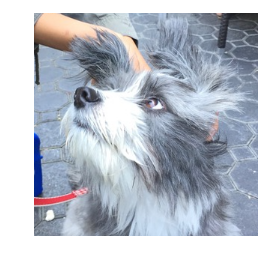

In [143]:
coco_image = mpimg.imread(os.path.join("images","cnn","coco.png"))[:, :, :channels]
plt.imshow(coco_image)
plt.axis("off")
plt.show()
coco_image = 2 * coco_image - 1

In [144]:
coco_test = coco_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: coco_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [145]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index
class_names[most_likely_class_index]

'Tibetan terrier, chrysanthemum dog'

In [146]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

Tibetan terrier, chrysanthemum dog: 64.40%
Australian terrier: 7.17%
Shih-Tzu: 1.83%
Lhasa, Lhasa apso: 1.69%
Yorkshire terrier: 1.41%


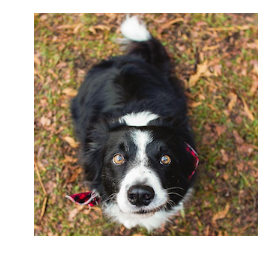

In [147]:
momo_image = mpimg.imread(os.path.join("images","cnn","momo.png"))[:, :, :channels]
plt.imshow(momo_image)
plt.axis("off")
plt.show()
momo_image = 2 * momo_image - 1

In [153]:
momo_test = momo_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: momo_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [154]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index
class_names[most_likely_class_index]

'Border collie'

In [155]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

Border collie: 74.20%
collie: 17.95%
flat-coated retriever: 0.14%
Appenzeller: 0.13%
Bernese mountain dog: 0.11%


## 9. Transfer learning for large image classification.

### 9.1.
Exercise: Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can just use an existing dataset, such as the [flowers dataset](https://goo.gl/EgJVXZ) or MIT's [places dataset](http://places.csail.mit.edu/) (requires registration, and it is huge).


Let's tackle the flowers dataset. First, we need to download it:

In [ ]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [ ]:
fetch_flowers()

Each subdirectory of the `flower_photos` directory contains all the pictures of a given class. Let's get the list of classes:

In [ ]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

Let's get the list of all the image file paths for each class:

In [ ]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

Let's sort the image paths just to make this notebook behave consistently across multiple runs:

In [ ]:
for paths in image_paths.values():
    paths.sort()    

Let's take a peek at the first few images from each class:

In [ ]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

Notice how the image dimensions vary, and how difficult the task is in some cases (e.g., the 2nd tulip image).

### 9.2.
Exercise: Write a preprocessing step that will resize and crop the image to 299 × 299, with some randomness for data augmentation.


First, let's implement this using NumPy and SciPy:

* using basic NumPy slicing for image cropping,
* NumPy's `fliplr()` function to flip the image horizontally (with 50% probability),
* and SciPy's `imresize()` function for zooming.
  * Note that `imresize()` is based on the Python Image Library (PIL).

For more image manipulation functions, such as rotations, check out [SciPy's documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/ndimage.html) or [this nice page](http://www.scipy-lectures.org/advanced/image_processing/).

In [ ]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255

Note: at test time, the preprocessing step should be as light as possible, just the bare minimum necessary to be able to feed the image to the neural network. You may want to tweak the above function to add a `training` parameter: if `False`, preprocessing should be limited to the bare minimum (i.e., no flipping the image, and just the minimum cropping required, preserving the center of the image).

Let's check out the result on this image:

In [ ]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

There we go:

In [ ]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Now let's look at a few other random images generated from the same original image:

In [ ]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

Looks good!

Alternatively, it's also possible to implement this image preprocessing step directly with TensorFlow, using the functions in the `tf.image` module (see [the API](https://www.tensorflow.org/api_docs/python/) for the full list). As you can see, this function looks very much like the one above, except it does not actually perform the image transformation, but rather creates a set of TensorFlow operations that *will* perform the transformation when you run the graph.

In [ ]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = number of channels

    # Let's crop the image using a random bounding box of the size we computed
    image = tf.random_crop(image, box_size)

    # Let's also flip the image horizontally with 50% probability:
    image = tf.image.random_flip_left_right(image)

    # The resize_bilinear function requires a 4D tensor (a batch of images)
    # so we need to expand the number of dimensions first:
    image_batch = tf.expand_dims(image, 0)

    # Finally, let's resize the image to the target dimensions. Note that this function
    # returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # back to a single image, and scale the colors from 0.0 to 1.0
    return image

Let's test this function!

In [ ]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: example_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Looks perfect!

### 9.3.
Exercise: Using the pretrained Inception v3 model from the previous exercise, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for your new classification task (e.g., the flowers dataset has five mutually exclusive classes so the output layer must have five neurons and use the softmax activation function).


Let's start by fetching the inception v3 graph again. This time, let's use a `training` placeholder that we will use to tell TensorFlow whether we are training the network or not (this is needed by operations such as dropout and batch normalization).

In [ ]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

Now we need to find the point in the graph where we should attach the new output layer.  It should be the layer right before the current output layer. One way to do this is to explore the output layer's inputs:  

In [ ]:
logits.op.inputs[0]

Nope, that's part of the output layer (adding the biases). Let's continue walking backwards in the graph:

In [ ]:
logits.op.inputs[0].op.inputs[0]

That's also part of the output layer, it's the final layer in the inception layer (if you are not sure you can visualize the graph using TensorBoard). Once again, let's continue walking backwards in the graph:

In [ ]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

Aha! There we are, this is the output of the dropout layer. This is the very last layer before the output layer in the Inception v3 network, so that's the layer we need to build upon. Note that there was actually a simpler way to find this layer: the `inception_v3()` function returns a dict of end points: 

In [ ]:
end_points

As you can see, the `"PreLogits"` end point is precisely what we need:

In [ ]:
end_points["PreLogits"]

We can drop the 2nd and 3rd dimensions using the `tf.squeeze()` function:

In [ ]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

Then we can add the final fully connected layer on top of this layer:

In [ ]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

Finally, we need to add the usual bits and pieces:

* the placeholder for the targets (`y`),
* the loss function, which is the cross-entropy, as usual for a classification task,
* an optimizer, that we use to create a training operation that will minimize the cost function,
* a couple operations to measure the model's accuracy,
* and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's `minimize()` method:

In [ ]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [ ]:
[v.name for v in flower_vars]

Notice that we created the `inception_saver` before adding the new output layer: we will use this saver to restore the pretrained model state, so we don't want it to try to restore new variables (it would just fail saying it does not know the new variables). The second `saver` will be used to save the final flower model, including both the pretrained variables and the new ones.

### 9.4.
Exercise: Split your dataset into a training set and a test set. Train the model on the training set and evaluate it on the test set.


First, we will want to represent the classes as ints rather than strings:

In [ ]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

It will be easier to shuffle the dataset set if we represent it as a list of filepath/class pairs:

In [ ]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

Next, lets shuffle the dataset and split it into the training set and the test set:

In [ ]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

Let's look at the first 3 instances in the training set:

In [35]:
flower_paths_and_classes_train[:3]

NameError: name 'flower_paths_and_classes_train' is not defined

Next, we will also need a function to preprocess a set of images. This function will be useful to preprocess the test set, and also to create batches during training. For simplicity, we will use the NumPy/SciPy implementation:

In [ ]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [ ]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [ ]:
X_batch.shape

In [ ]:
X_batch.dtype

In [ ]:
y_batch.shape

In [ ]:
y_batch.dtype

Looking good. Now let's use this function to prepare the test set:

In [ ]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [ ]:
X_test.shape

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

In [ ]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [ ]:
X_test.shape

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

In [ ]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_flowers_model")

In [ ]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

Okay, 70.58% accuracy is not great (in fact, it's really bad), but this is only after 10 epochs, and freezing all layers except for the output layer. If you have a GPU, you can try again and let training run for much longer (e.g., using early stopping to decide when to stop). You can also improve the image preprocessing function to make more tweaks to the image (e.g., changing the brightness and hue, rotate the image slightly). You can reach above 95% accuracy on this task. If you want to dig deeper, this [great blog post](https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html) goes into more details and reaches 96% accuracy.

## 10.
Exercise: Go through TensorFlow's [DeepDream tutorial](https://goo.gl/4b2s6g). It is a fun way to familiarize yourself with various ways of visualizing the patterns learned by a CNN, and to generate art using Deep Learning.


Simply download the notebook and follow its instructions. For extra fun, you can produce a series of images, by repeatedly zooming in and running the DeepDream algorithm: using a tool such as [ffmpeg](https://ffmpeg.org/) you can then create a video from these images. For example, here is a [DeepDream video](https://www.youtube.com/watch?v=l6i_fDg30p0) I made... as you will see, it quickly turns into a nightmare. ;-) You can find hundreds of [similar videos](https://www.youtube.com/results?search_query=+deepdream) (often much more artistic) on the web.